### Language modeling is the task of predicting the next word, given the preceding history.

### Sentiment detection is just a special case of classification

**Data sets with fields:**

*Combined_Comments* := comment_id, author, author_flair, score, comment_name, comment_fullname, comment_is_root, comment_parent, comment_created, comment_created_utc, comment_created_utc_datetime, comment_created_utc_date, comment_created_utc_time, comment_depth, comment_body, submission_id, submission_title, submission_created_utc**

*Clean_Game_Data* := index, unnamed: 0, playnum, playid, 'Game Title Date', text, homeWinPercentage, matched_play_by_play_text, matched_play_by_play_index, matched_play_by_play_utc, matched_play_by_play_tweetid, home_team, away_team, awayWinPercentage

*Pickle files in Clean_Game_Data* := author, author_flair, score, comment_id, comment_name, comment_fullname, comment_is_root, comment_parent, comment_approved_at_utc, comment_approved_by, matched_play_by_play_utc, matched_play_by_play_tweetid, home_team, away_team, awayWinPercentage, vader_ss, vader_neg, vader_neu, vader_pos, vader_compound

*Comments_FanOfGame* := comment_body (from Reddit), fan_of_team_playing


**Ideas for data to model**

*-------------1-------------*

*Dependent var* := game state

*Independent vars* := comment_body, fan_of_team_playing

*-------------2-------------*

*Dependent var* := fan_of_team_playing

*Independent vars* := comment_body, game_state

*-------------3-------------*

*Dependent var* := author_flair

*Independent vars* := comment_body, game_fan_state (fan_team_prob_win, fan_team_prob_lose, fan_no_team)

*-------------4-------------*

*Dependent var* := author_game_state or game_fan_state (fan_team_prob_win, fan_team_prob_lose, fan_no_team)

*Independent vars* := comment_body

*-------------5-------------*

*Dependent var* := next word

*Independent vars* := previous word


*--------------------------*

*Next step* := apply language model to each game and examine by game_state, fan_of_team_playing

**Possible comment label combinations (author_game_state)**

*fan/close*

*fan/blowout*

*notfan/close*

*notfan/blowout*

*fan/lose*

*fan/win*

In [1]:
import numpy as np
import pandas as pd
import re
import pickle
import itertools
from __future__ import print_function
from __future__ import division
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
#from sklearn.pipeline import Pipeline
#from sklearn.grid_search import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# NLTK libs
from nltk.tokenize import TweetTokenizer

## Data Processing

In [3]:
## Load combined comments
data_path = "/Users/kwheatley/Desktop/w266_nfl/"
lookup_path = "/Users/kwheatley/w266_final_project_merged/data/"
combined_comments = 'Combined_Comments.csv'
flair_lookup = 'flair_lookup_table.csv'
game_stats = 'game_stats.csv'

data = pd.read_csv(data_path+combined_comments)
flair_lookup_table = pd.read_csv(lookup_path+flair_lookup)
game_stats = pd.read_csv(lookup_path+game_stats)
data = data.set_index('submission_title')
game_stats = game_stats.set_index('submission_title')
data = data.join(game_stats, how='outer')
data = data.set_index('author_flair')
flair_lookup_table = flair_lookup_table.set_index('author_flair')
data = data.join(flair_lookup_table, how='outer')

### Create features for model

In [35]:
# Creating targets for testing

# 1. Fan of winning or losing team or other
data['win_lost_fan_type'] = np.where(data.author_team_name == data.winner, 'win',
                            np.where(data.author_team_name == data.loser, 'lose', 'nofan'))

# 2. Score differential
data['score_differential'] = data.ptsw - data.ptsl

# 3. Yards differential (absolute value)
data['yards_differential'] = abs(data.ydsw - data.ydsl)

# 4. Total turnovers in game
data['turn_over_differential'] = data.tol + data.tol

# 5. Watching close game or not (within 7 points)
data['close_game'] = np.where(data.score_differential <= 7, 'close','not close')

# 6. Fan lost/won close game or not (within 7 points)
data['fan_close_game'] = data.win_lost_fan_type + ' ' + data.is_close_game


In [34]:
data[data.submission_title == 'Game Thread: Atlanta Falcons (10-6) at Los Angeles Rams (11-5)'].head()

,submission_title,comment_id,author,score,comment_name,comment_fullname,comment_is_root,comment_parent,comment_created,comment_created_utc,...,tol,home_team.1,away_team.1,author_team_name,fan_type,home_away_fan_type,win_lost_fan_type,score_differential,yards_differential,is_close_game
author_flair,,,,,,,,,,,,,,,,,,,,,
49ers,Game Thread: Atlanta Falcons (10-6) at Los Ang...,dsau5nl,TonyDHFC,57,t1_dsau5nl,t1_dsau5nl,True,7onb6d,1.515318e+09,1.515289e+09,...,2.0,Los Angeles Rams,Atlanta Falcons,San Francisco 49ers,nofan,nofan,nofan,13.0,4.0,nofan not close
49ers,Game Thread: Atlanta Falcons (10-6) at Los Ang...,dsaxh3a,The_Collector4,27,t1_dsaxh3a,t1_dsaxh3a,True,7onb6d,1.515322e+09,1.515293e+09,...,2.0,Los Angeles Rams,Atlanta Falcons,San Francisco 49ers,nofan,nofan,nofan,13.0,4.0,nofan not close
49ers,Game Thread: Atlanta Falcons (10-6) at Los Ang...,dsavilr,philphan25,21,t1_dsavilr,t1_dsavilr,True,7onb6d,1.515319e+09,1.515291e+09,...,2.0,Los Angeles Rams,Atlanta Falcons,San Francisco 49ers,nofan,nofan,nofan,13.0,4.0,nofan not close
49ers,Game Thread: Atlanta Falcons (10-6) at Los Ang...,dsawdu3,WigglestonTheFourth,23,t1_dsawdu3,t1_dsawdu3,True,7onb6d,1.515320e+09,1.515292e+09,...,2.0,Los Angeles Rams,Atlanta Falcons,San Francisco 49ers,nofan,nofan,nofan,13.0,4.0,nofan not close
49ers,Game Thread: Atlanta Falcons (10-6) at Los Ang...,dsatn4f,-generic_user-,21,t1_dsatn4f,t1_dsatn4f,True,7onb6d,1.515317e+09,1.515288e+09,...,2.0,Los Angeles Rams,Atlanta Falcons,San Francisco 49ers,nofan,nofan,nofan,13.0,4.0,nofan not close


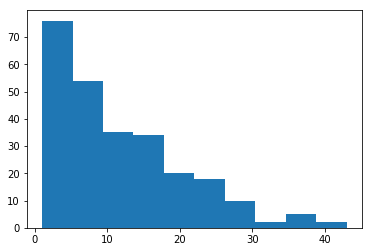

In [29]:
# This histogram shows us the point differentials between all the games we 
# have on record. There are a large number of close games. 
hist_data = data[data.score_differential.notnull()].groupby('submission_title')\
    ['score_differential'].min().reset_index()
plt.hist(hist_data.score_differential,)
plt.show()

### Define helper functions

In [36]:
# Borrowed some functions from the w266 utils.py file
# Miscellaneous helpers
def flatten(list_of_lists):
    """Flatten a list-of-lists into a single list."""
    return list(itertools.chain.from_iterable(list_of_lists))


# Word processing functions
def canonicalize_digits(word):
    if any([c.isalpha() for c in word]): return word
    word = re.sub("\d", "DG", word)
    if word.startswith("DG"):
        word = word.replace(",", "") # remove thousands separator
    return word

def canonicalize_word(word, wordset=None, digits=True):
    word = re.sub(r"(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w\.-]*)*\/?\S*", "postedhyperlinkvalue", word)
    word = re.sub(r"(postedhyperlinkvalue)+", "postedhyperlinkvalue", word)
    #if not word.isupper():
    word = word.lower()
    if digits:
        if (wordset != None) and (word in wordset): return word
        word = canonicalize_digits(word) # try to canonicalize numbers
    if (wordset == None) or (word in wordset):
        return word
    else:
        return constants.UNK_TOKEN

def canonicalize_words(words, **kw):
    return [canonicalize_word(word, **kw) for word in words]

In [37]:
def make_data(data, 
              only_fans=False, 
              no_empty=True, 
              tail_win_diffs=False, tokenizer=TweetTokenizer(), canonize=True):
    use_data = data
    
    if only_fans:
        # Get rid of non-fans
        use_data = use_data[use_data['fan_type']!='nofan']
    
    if no_empty:
        # Eliminate data with empty comments
        use_data = use_data[pd.notnull(use_data['comment_body'])]
        
    if tail_win_diffs:
        # Eliminate data for games in which the outcome is neither very close nor very clear
        use_data = use_data[(use_data['win_differential'] <= 0.2) | (use_data['win_differential'] >= 0.9)]

    # Separate comments
    comments = use_data.loc[:, 'comment_body']
    
    # Convert to list
    comment_list = comments.values.tolist()
    
    # Tokenize comments
    tokenizer = tokenizer
    x_tokens = [tokenizer.tokenize(sentence) for sentence in comment_list]
    
    if canonize:
        comments_canon = []
        for token in x_tokens:
            x_tokens_canon = canonicalize_words(token)
            comments_canon.append(x_tokens_canon)
        x_tokens = comments_canon
    
    return use_data, comments, comment_list, x_tokens

def most_informative_features_top_and_bottom(vectorizer, classifier, binary=True, n=10):
    
    feature_names = vectorizer.get_feature_names()
    
    '''classifier.coef_[0],''' 
    if binary:
        class_labels = classifier.classes_
        topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
        topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
        for coef, feat in topn_class1:
            print (class_labels[0], coef, feat)

        print()

        for coef, feat in reversed(topn_class2):
            print (class_labels[1], coef, feat)
    
    else:
        notclose_feats = sorted(zip(classifier.coef_, feature_names))[-n:]
        close_feats = sorted(zip(classifier.coef_, feature_names))[:n]
        
        for coef, feat in close_feats:
            print ("Close", coef, feat)
        
        print()
        
        for coef, feat in reversed(notclose_feats):
            print ("Not close", coef, feat)

### Prepare the data for modeling

In [ ]:
# 1. win_lost_fan_type : Fan of winning or losing team or other
# 2. score_differential : Score differential
# 3. yards_differential : Yards differential (absolute value)
# 4. turn_over_differential : Total turnovers in game
# 5. close_game : Watching close game or not (within 7 points)
# 6. fan_close_game : Fan lost/won close game or not (within 7 points)

In [55]:
use_data.groupby('win_lost_fan_type')['comment_body'].count()

win_lost_fan_type
lose      350883
nofan    1142474
win       524654
Name: comment_body, dtype: int64

In [56]:
data.groupby('win_lost_fan_type')['comment_body'].count()

win_lost_fan_type
lose      350883
nofan    1142474
win       524654
Name: comment_body, dtype: int64

### Set dependent variable

In [54]:
use_data, comments, comment_list, x_tokens = make_data(data, only_fans=False, tail_win_diffs=False)

In [57]:
# Isolate the labels
target_var = 'win_lost_fan_type'

labels = use_data.loc[:, target_var]

counts = {}
for label in np.unique(labels):
    counts[label] = sum(labels == label)

print("Class counts:\n{}".format(counts))

Class counts:
{'lose': 350883, 'nofan': 1142474, 'win': 524654}


### Multinomial Naive Bayes

In [59]:
print(type(x_tokens))
print(len(x_tokens))
print(x_tokens[83029])

<class 'list'>
2018011
['goff', 'needs', 'his', 'safety', 'blanket', '.']


In [60]:
# Count or TF-IDF vectorize, removing stop words.
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', lowercase=False, 
                             tokenizer=lambda text: text)
                             #tokenizer=lambda text: text, min_df=0.00002, max_df=0.005)
spmat = vectorizer.fit_transform(x_tokens)
#vectorizer = CountVectorizer(analyzer='word', stop_words='english', lowercase=False, binary=False)
#spmat = vectorizer.fit_transform(X_data)

/Users/kwheatley/anaconda/envs/python36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [61]:
# Split into test and train
train_data, test_data, train_labels, test_labels = train_test_split(spmat, labels, test_size=0.10, random_state=42)  

In [62]:
# Train model
#a_values = [x * 0.01 for x in range(1,20)]
#gs_mnb = GridSearchCV(MultinomialNB(), {'alpha': a_values}, cv=5,
#                       scoring='f1_weighted')
clf = MultinomialNB()
clf.fit(train_data, train_labels)
#print(gs_mnb.best_estimator_)
#print(gs_mnb.best_score_)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [63]:
print(clf.class_count_)

[ 315703. 1028128.  472378.]


In [64]:
# Get feature names and class labels
feature_names = vectorizer.get_feature_names()
class_labels = clf.classes_
print(class_labels)

['lose' 'nofan' 'win']


In [65]:
# Create predictions and evaluate
pred_labels = clf.predict(test_data)
acc = metrics.accuracy_score(test_labels, pred_labels)
print("Accuracy on test set: {:.02%}".format(acc))
print('Test Data:')

print(classification_report(test_labels, pred_labels, target_names = class_labels, digits=3))

print("Confusion Matrix...")
confusionMatrix = metrics.confusion_matrix(test_labels, pred_labels)
print(confusionMatrix)

Accuracy on test set: 57.02%
Test Data:
             precision    recall  f1-score   support

       lose      0.368     0.010     0.020     35180
      nofan      0.574     0.982     0.724    114346
        win      0.474     0.046     0.084     52276

avg / total      0.512     0.570     0.436    201802

Confusion Matrix...
[[   360  33837    983]
 [   364 112285   1697]
 [   253  49607   2416]]


In [66]:
# Which is the "default" class, i.e. that class predicted against no features? Let's test it.
#print(spmat)
#print(pred)
print(clf.intercept_)
for word in ['###bruh','###mods','##mikeshula','#analysis','Van Buren','.',',','fuck','good']:
    test_word = vectorizer.transform([[word]])
    pred = clf.predict(test_word)
    print(word, ": ", pred)
# It's 'notclose' because that is the default prediction.

[-1.74970474 -0.56901169 -1.34672713]
###bruh :  ['win']
###mods :  ['lose']
##mikeshula :  ['win']
#analysis :  ['nofan']
Van Buren :  ['nofan']
. :  ['nofan']
, :  ['nofan']
fuck :  ['nofan']
good :  ['nofan']


/Users/kwheatley/anaconda/envs/python36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [67]:
# Get most informative features
most_informative_features_top_and_bottom(vectorizer=vectorizer, classifier=clf, binary=True, n=15)

lose -13.658624786564527 ###adam
lose -13.658624786564527 ###ahh
lose -13.658624786564527 ###alert
lose -13.658624786564527 ###all
lose -13.658624786564527 ###almichaelsshakeyabooty
lose -13.658624786564527 ###and
lose -13.658624786564527 ###another
lose -13.658624786564527 ###at
lose -13.658624786564527 ###bersin
lose -13.658624786564527 ###big
lose -13.658624786564527 ###blew
lose -13.658624786564527 ###block
lose -13.658624786564527 ###boobiessssssss
lose -13.658624786564527 ###brock
lose -13.658624786564527 ###broncos

nofan -3.683993892061711 .
nofan -4.4631088527274265 ,
nofan -4.555669968170468 ?
nofan -4.9446285190062955 !
nofan -5.087757103587803 fuck
nofan -5.153722910707264 game
nofan -5.2991215958049676 ...
nofan -5.349687943159118 fucking
nofan -5.359995492035001 just
nofan -5.410017269851206 DG
nofan -5.438553954837262 like
nofan -5.474018179893259 lol
nofan -5.563917654941019 good
nofan -5.600317137204122 ’
nofan -5.686292776473958 "


### Logistic Regression

### Vectorize data and split into train and test

Reuse data prep, vectorization, and train/test split from Naive Bayes 

In [74]:
# Train model
lgreg = LogisticRegression()
lgreg.fit(train_data, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [75]:
#Create predictions and evaluate
pred_labels = lgreg.predict(test_data)
acc = metrics.accuracy_score(test_labels, pred_labels)
print("Accuracy on test set: {:.02%}".format(acc))
print('Test Data:')

print(classification_report(test_labels, pred_labels, target_names = class_labels, digits=3))
#print(classification_report(test_labels, pred_labels, target_names = ['fan_lose_close', 'fan_lose_notclose', 'fan_win_close', 'fan_win_notclose'], digits=3))

print("Confusion Matrix...")
confusionMatrix = metrics.confusion_matrix(test_labels, pred_labels)
print(confusionMatrix)

Accuracy on test set: 57.61%
Test Data:
             precision    recall  f1-score   support

       lose      0.421     0.044     0.079     35180
      nofan      0.589     0.953     0.728    114346
        win      0.438     0.109     0.175     52276

avg / total      0.521     0.576     0.472    201802

Confusion Matrix...
[[  1531  30599   3050]
 [  1040 109018   4288]
 [  1062  45497   5717]]


In [76]:
# Which is the "default" class, i.e. that class predicted against no features? Let's test it.
#print(spmat)
#print(pred)
print(lgreg.intercept_)
for word in ['vernon','foles','bersin','mills','Van Buren','glennon','fog','onside','achilles']:
    test_word = vectorizer.transform([[word]])
    pred = lgreg.predict(test_word)
    print(word, ": ", pred)
# It's 'close' because that is the default prediction.

[-1.63750709  0.18752951 -0.96315531]
vernon :  ['nofan']
foles :  ['nofan']
bersin :  ['win']
mills :  ['win']
Van Buren :  ['nofan']
glennon :  ['nofan']
fog :  ['win']
onside :  ['nofan']
achilles :  ['nofan']


/Users/kwheatley/anaconda/envs/python36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [79]:
# Get most informative features
most_informative_features_top_and_bottom(vectorizer=vectorizer, classifier=lgreg, binary=False, n=15)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### Formulate the problem as a regression problem

### Prepare the data for modeling

We will begin by using the same data that we used for classification. We will later model all of the tweets in our corpus. In both cases, our target variable will be win_differential, a continuous variable.

In [73]:
use_data, comments, comment_list, x_tokens = make_data(data, only_fans=False, tail_win_diffs=False)

### Set dependent variable

In [78]:
target_var = 'win_lost_fan_type'
y_data = use_data.loc[:, target_var]

### Vectorize data and split into train and test

We will vectorize a bit differently for regression. We will use binary variables to indicate the presence or absence of a word, rather than model counts or tf-idf, as we did for classification.

In [350]:
vectorizer = CountVectorizer(analyzer='word', stop_words='english', tokenizer=lambda text: text, 
                             lowercase=False, binary=True)#, min_df=10)
spmat = vectorizer.fit_transform(x_tokens)

In [351]:
# Split into test and train
train_data, test_data, train_labels, test_labels = train_test_split(spmat, y_data, test_size=0.10, random_state=42)  

In [352]:
print(len(x_tokens))

83030


### Linear Regression

In [355]:
# Train model
lr = LinearRegression()
lr.fit(train_data, train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [356]:
#Create predictions and evaluate
pred_labels = lr.predict(test_data)
print("Training set score: {:.2f}".format(lr.score(train_data, train_labels)))
print("Test set score: {:.2f}".format(lr.score(test_data, test_labels)))

Training set score: 0.39
Test set score: -0.19


In [361]:
# Get most informative features
most_informative_features_top_and_bottom(vectorizer=vectorizer, classifier=lr, binary=False, n=15)

Close -2.301957306899027 namath's
Close -2.1877138727182457 richardwashington
Close -1.9732911747672395 toothpaste
Close -1.963828160231887 taunts
Close -1.9101269513392856 syrup
Close -1.908013352218731 compulsively
Close -1.9058120694474192 preference
Close -1.852787000670881 exhange
Close -1.7886163110315205 described
Close -1.7797319522554074 skeletons
Close -1.7127994796526567 nord
Close -1.6951090696767224 septum
Close -1.6668677396222211 virgil
Close -1.662375903737923 needy
Close -1.6219303976219441 hahahahahahahahahahahahahahahahahahahahahahahahahahahahahhahahahajahahajhahajajajajajjahahahahhahahahahahahahhahahahahhahahahahajhajajajhahahhahah

Not close 2.5271981827317336 urinatingtree
Not close 2.2475460065967634 comings
Not close 2.2344195914329417 sported
Not close 2.096146291596809 baaaaaad
Not close 2.083090275841373 pleaseee
Not close 1.9456278595420349 chamionship
Not close 1.9368067779277969 va
Not close 1.9268929341089498 nintendo
Not close 1.9236111584623041 kalifa
N

### Lasso Regression

In [139]:
lasso = Lasso(alpha=0.0002)
lasso.fit(train_data, train_labels)

Lasso(alpha=0.0002, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [140]:
#Create predictions and evaluate
pred_labels = lasso.predict(test_data)
print("Training set score: {:.2f}".format(lasso.score(train_data, train_labels)))
print("Test set score: {:.2f}".format(lasso.score(test_data, test_labels)))
print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))

Training set score: 0.06
Test set score: 0.05
Number of features used: 239


In [362]:
# Get most informative features
most_informative_features_top_and_bottom(vectorizer=vectorizer, classifier=lasso, binary=False, n=15)

Close -0.1637421717990017 foles
Close -0.1581467866956226 ebron
Close -0.14852478955757265 shazier
Close -0.1267352788009385 bounds
Close -0.12101580068333978 penalty
Close -0.11625071424487275 penalties
Close -0.11154985669594393 tackle
Close -0.10665208565190892 kamara
Close -0.09018074264763473 ab
Close -0.08698765710318315 gronk
Close -0.08640963325996047 ben
Close -0.0804754389359069 drive
Close -0.0788042281287264 eagles
Close -0.07497130441441537 weak
Close -0.07423865843002164 gruden

Not close 0.3508173499098539 fog
Not close 0.32338060317444955 gg
Not close 0.30864989421356875 glennon
Not close 0.27611114955949473 bears
Not close 0.2504264555094252 trevathan
Not close 0.19970469311750266 adams
Not close 0.18013604448015075 mcadoo
Not close 0.17551875308471257 obj
Not close 0.1660806503818626 siemian
Not close 0.16490772884150776 capers
Not close 0.16345146448162082 onside
Not close 0.15842325520283113 packers
Not close 0.149615659685727 fox
Not close 0.13986722855251074 ap
No

### Ridge Regression

In [136]:
rdg = Ridge(alpha=5)
rdg.fit(train_data, train_labels)

Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [137]:
#Create predictions and evaluate
pred_labels = rdg.predict(test_data)
print("Training set score: {:.2f}".format(rdg.score(train_data, train_labels)))
print("Test set score: {:.2f}".format(rdg.score(test_data, test_labels)))
#print("Number of features used: {}".format(np.sum(clf.coef_ != 0)))

Training set score: 0.25
Test set score: 0.09


In [138]:
# Look at top scoring words
n = 20
print(rdg.coef_.shape)
feature_names = vectorizer.get_feature_names()
top_feats = np.argsort(rdg.coef_)[-n:]
print("Top Feats:")
print(" ".join(feature_names[j] for j in top_feats))

bottom_feats = np.argsort(rdg.coef_)[:n]
print("Bottom feats:")
print(" ".join(feature_names[j] for j in bottom_feats))

(25649,)
Top Feats
pouncey semen naz mcadoo hyde marshall touchback legion achilles doink siemian shutout trevathan callahan glennon jordy onside gg colt fog
Bottom feats:
vernon kalil mccourty quin hightower pagano roberts bersin foles cart foreman remmers morelli dupree week's strief trufant barry tree jameis


In [363]:
# Get most informative features
most_informative_features_top_and_bottom(vectorizer=vectorizer, classifier=rdg, binary=False, n=15)

Close -0.37089561368148444 vernon
Close -0.3705410714883797 kalil
Close -0.366058386686205 mccourty
Close -0.34349630756545807 quin
Close -0.3269397831598419 hightower
Close -0.2951402671672529 pagano
Close -0.2936702152555754 roberts
Close -0.293312067455661 bersin
Close -0.2911020761305688 foles
Close -0.2830976737857898 cart
Close -0.2790687785902987 foreman
Close -0.27894208442918456 remmers
Close -0.2761260702074843 morelli
Close -0.2750799921285882 dupree
Close -0.27415810563194515 week's

Not close 0.3870118227815891 fog
Not close 0.3488107110816733 colt
Not close 0.34809381861857464 gg
Not close 0.3378369357798525 onside
Not close 0.3331272705315328 jordy
Not close 0.3271165479385764 glennon
Not close 0.32286493690954166 callahan
Not close 0.31772959994818584 trevathan
Not close 0.3112715472382765 shutout
Not close 0.30460266590220025 siemian
Not close 0.28955949885272886 doink
Not close 0.2887701078910159 achilles
Not close 0.2865772299529646 legion
Not close 0.285416572055834

### ElasticNet Regression

In [364]:
elnet = ElasticNet(alpha=0.0001, l1_ratio=0.25)
elnet.fit(train_data, train_labels)

ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.25,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [365]:
#Create predictions and evaluate
pred_labels = elnet.predict(test_data)
print("Training set score: {:.2f}".format(elnet.score(train_data, train_labels)))
print("Test set score: {:.2f}".format(elnet.score(test_data, test_labels)))
print("Number of features used: {}".format(np.sum(elnet.coef_ != 0)))

Training set score: 0.13
Test set score: 0.09
Number of features used: 2537


In [367]:
# Get most informative features
most_informative_features_top_and_bottom(vectorizer=vectorizer, classifier=elnet, binary=False, n=15)

Close -0.324841966737298 kalil
Close -0.3146510801148604 vernon
Close -0.2838590936084882 quin
Close -0.2813916141390773 hightower
Close -0.27632289179523634 foles
Close -0.2613953794039104 roberts
Close -0.24014317180145764 lattimore
Close -0.23842951744757415 ebron
Close -0.235139838229948 shazier
Close -0.21848218713247713 mccourty
Close -0.2172652142529246 anthem
Close -0.21607765388885264 pagano
Close -0.21562798692136326 runoff
Close -0.21538195151350967 ab
Close -0.21369460966003695 bersin

Not close 0.3870039726414069 fog
Not close 0.3453605426586392 gg
Not close 0.3275875380138656 glennon
Not close 0.31437742763067766 onside
Not close 0.31060685929617404 jordy
Not close 0.2976617029931883 trevathan
Not close 0.28969766100465266 achilles
Not close 0.28741106657263643 siemian
Not close 0.27876994777062925 colt
Not close 0.274823164042374 mcadoo
Not close 0.2712215477393702 shutout
Not close 0.2696461025226082 bears
Not close 0.2618729971057421 ap
Not close 0.250878211572743 van


### Rerun regressions against the full corpus of tweets

In [368]:
use_data, comments, comment_list, x_tokens = make_data(data)

In [369]:
print(len(x_tokens))

588378


### Set dependent variable

In [370]:
target_var = 'win_differential'
y_data = use_data.loc[:, target_var]

### Vectorize data and split into train and test

We will require that each word appear in at least five posts, in order to make the problem a bit more tractable. The full vocabulary is ~73,000 words.

In [371]:
vectorizer = CountVectorizer(analyzer='word', stop_words='english', tokenizer=lambda text: text, 
                             lowercase=False, binary=True, min_df=5)
spmat = vectorizer.fit_transform(x_tokens)

In [372]:
print(spmat.shape)

(588378, 20271)


In [373]:
# Split into test and train
train_data, test_data, train_labels, test_labels = train_test_split(spmat, y_data, test_size=0.10, random_state=42)  

### Linear Regression

In [374]:
# Train model
lr2 = LinearRegression()
lr2.fit(train_data, train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [375]:
#Create predictions and evaluate
pred_labels = lr2.predict(test_data)
print("Training set score: {:.2f}".format(lr2.score(train_data, train_labels)))
print("Test set score: {:.2f}".format(lr2.score(test_data, test_labels)))

Training set score: 0.11
Test set score: 0.04


In [385]:
# Get most informative features
most_informative_features_top_and_bottom(vectorizer=vectorizer, classifier=lr2, binary=False, n=15)

Close -0.7366365776764944 proverbs
Close -0.614864818464966 addlepated
Close -0.5911869096868527 septum
Close -0.5459193059956473 ヽ
Close -0.538375631212161 pagano's
Close -0.5225480071446668 ʖ
Close -0.5206434806763558 kat
Close -0.5171707112241234 dissonance
Close -0.4888377564302402 fortnight
Close -0.4732244681743223 lisa's
Close -0.4716387420594738 ving
Close -0.4600918957868638 truf
Close -0.4541646346885054 gano's
Close -0.45134385673988614 alualu
Close -0.445996111603729 wendell

Not close 0.9332597276422983 suckle
Not close 0.5798348489428313 cbssports
Not close 0.5741131387170613 blossoms
Not close 0.5324130041259257 mcaddo
Not close 0.5309113250049071 plagued
Not close 0.503585671806284 mcfucked
Not close 0.489717435230355 selena
Not close 0.47978378401792204 recruits
Not close 0.47950918613171506 try-hard
Not close 0.47247821562318587 wilfs
Not close 0.4616409902542392 panting
Not close 0.4549402007637534 mmmphmmgofgpsngfjg
Not close 0.44897514957153245 smithfest
Not close 

### Lasso Regression

In [377]:
lasso2 = Lasso(alpha=0.0002)
lasso2.fit(train_data, train_labels)

Lasso(alpha=0.0002, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [378]:
#Create predictions and evaluate
pred_labels = lasso2.predict(test_data)
print("Training set score: {:.2f}".format(lasso2.score(train_data, train_labels)))
print("Test set score: {:.2f}".format(lasso2.score(test_data, test_labels)))
print("Number of features used: {}".format(np.sum(lasso2.coef_ != 0)))

Training set score: 0.02
Test set score: 0.02
Number of features used: 84


In [380]:
# Get most informative features
most_informative_features_top_and_bottom(vectorizer=vectorizer, classifier=lasso2, binary=False, n=15)

Close -0.06674596344399168 jags
Close -0.04973600300560194 watson
Close -0.04252400099732609 penalties
Close -0.038285407070360454 bortles
Close -0.0331451635148278 penalty
Close -0.033133304649292705 gronk
Close -0.02724073141586378 shazier
Close -0.023198475552050065 flag
Close -0.021524735007958106 bengals
Close -0.020814819589663643 smith
Close -0.01903731116145075 refs
Close -0.015621098236632045 tackle
Close -0.014798256861607169 drive
Close -0.01300520317597305 commercial
Close -0.012922063891162138 flags

Not close 0.25772776639078987 glennon
Not close 0.22660532698518207 fog
Not close 0.22053361404586766 bears
Not close 0.11358554126934853 gg
Not close 0.09640465547550058 packers
Not close 0.0765417807928123 adams
Not close 0.07027087730101018 fumble
Not close 0.05628949890659012 trevathan
Not close 0.0429045972172904 giants
Not close 0.03403063132963827 mcadoo
Not close 0.03178761742048484 broncos
Not close 0.030474281283239906 rodgers
Not close 0.02772933146181787 team
Not c

### Ridge Regression

In [381]:
rdg2 = Ridge(alpha=5)
rdg2.fit(train_data, train_labels)

Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [382]:
#Create predictions and evaluate
pred_labels = rdg2.predict(test_data)
print("Training set score: {:.2f}".format(rdg2.score(train_data, train_labels)))
print("Test set score: {:.2f}".format(rdg2.score(test_data, test_labels)))

Training set score: 0.11
Test set score: 0.06


In [383]:
# Get most informative features
most_informative_features_top_and_bottom(vectorizer=vectorizer, classifier=rdg2, binary=False, n=15)

Close -0.3341167494480762 clowney
Close -0.33140581288740717 jurassic
Close -0.3083753478676579 jeter
Close -0.2889167086397757 mathieu
Close -0.27949676093862186 devey
Close -0.27526790450294114 usain
Close -0.2746238409376355 edp
Close -0.2707520313300666 bersin
Close -0.26949341370534247 veldheer
Close -0.2692300694737256 goldblum
Close -0.26899796103714735 ving
Close -0.2670117153388828 ldt
Close -0.26562120432521164 starz
Close -0.2605673264945358 eifert
Close -0.2594601713360077 morrow

Not close 0.33960576417701027 fog
Not close 0.328571699447289 paxton
Not close 0.32750834280102536 trevathan
Not close 0.3190048143851692 pouncey
Not close 0.3058202724304288 shutouts
Not close 0.30378279395387053 semen
Not close 0.3014319009686111 gamblers
Not close 0.29704882022425944 shutout
Not close 0.29595901330127494 travathan
Not close 0.2854799527746833 glennon
Not close 0.2833101852699645 bellamy
Not close 0.2791215291909904 siemian
Not close 0.2784716481623642 trevethan
Not close 0.2757

### ElasticNet Regression

In [384]:
elnet2 = ElasticNet(alpha=0.0001, l1_ratio=0.25)
elnet2.fit(train_data, train_labels)

ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.25,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [386]:
#Create predictions and evaluate
pred_labels = elnet2.predict(test_data)
print("Training set score: {:.2f}".format(elnet2.score(train_data, train_labels)))
print("Test set score: {:.2f}".format(elnet2.score(test_data, test_labels)))
print("Number of features used: {}".format(np.sum(elnet2.coef_ != 0)))

Training set score: 0.05
Test set score: 0.05
Number of features used: 1020


In [388]:
# Get most informative features
most_informative_features_top_and_bottom(vectorizer=vectorizer, classifier=elnet2, binary=False, n=15)

Close -0.18979554861383502 ebron
Close -0.18629209234691022 vernon
Close -0.17537641871499493 clowney
Close -0.16389916615075623 kamara
Close -0.15190543687109095 watson
Close -0.1420085719023058 lattimore
Close -0.13344412881758297 larry
Close -0.13082635907461526 shazier
Close -0.128307898715521 foles
Close -0.12609283939487415 intro
Close -0.12390320499273695 carrie
Close -0.1168952546123918 legs
Close -0.11248513106204548 deuce
Close -0.10470155206766742 computer
Close -0.10306873347352419 texans

Not close 0.3200363972504439 fog
Not close 0.2888201484358086 glennon
Not close 0.2787606782216231 trevathan
Not close 0.2395484474181883 siemian
Not close 0.22729796566245736 bears
Not close 0.2074052216930885 achilles
Not close 0.20241284659580414 gg
Not close 0.18913033440652097 onside
Not close 0.17930686718319125 lightning
Not close 0.17702003217967155 trubisky
Not close 0.16691590432879885 thumbs
Not close 0.16369004359667322 adams
Not close 0.1579198513780052 shutout
Not close 0.15

In [394]:
print(comment_list[0])
print(x_tokens[0])

[jersey goals](https://i.ebayimg.com/images/g/9ncAAOxyGqZSWoeL/s-l300.jpg)
['[', 'jersey', 'goals', ']', '(', 'postedhyperlinkvalue', ')']


In [409]:
i = 0
for comment, token_list in zip(comment_list, x_tokens):
    for token in token_list:
        if token == 'foles':
            print(i, ": ", comment)
    i += 1

48330 :  Yep that's why Nick Foles is the best QB ever

And awards aren't perfect... otherwise Bill Belichick would win coach of the year every single year. People vote for the hot shiny new object.
51732 :  Wentz
Kirk
Eli
Foles
Dak

did i get this right?
51737 :  Foles > Dak
51768 :  Wentz, Cousins, Eli, Foles, Dak.

NFC East QBs in order
51866 :  7TD in a game Foles
53573 :  ...Nick Foles is 4th, right?
53588 :  Time to stop cherry picking stats Cowboys fans. Your quarterback is a mediocre game manager who can't win games without an elite cast. At least Foles still took shots down the field in his decline. He's not quite an Alex Smith ceiling, but not quite an Osweiler floor.
53687 :  Seriously Cowboys should give us a 3rd for Foles at the end of the season.  He's absolutely better than Dak.
53696 :  I was thinking Tress way, the redskins punter who has a 100% career completion rating, but with Rush and Foles it’s safe to say Dak is 7th 
53848 :  Let me put it like this, I wouldn't t

381178 :  A dumb football thing, but I always find myself astounded at just how long 15 seconds is. At 15 seconds, they were still in the huddle and I think Foles was still reading the play. That seems like no time at all, and yet they found the time to get the snap off with seconds to spare. 
381193 :  Foles thought Celek was Ertz
381198 :  Foles is loving the tight ends this game. 
381207 :  Nick Foles earning his paycheck right now
381237 :  Foles is Dakking his way up the field
381239 :  Foles baby. Cmon bro
381256 :  Foles is still more accurate than Dak

381260 :  Nick "Alex "Checkdown" Smith" Foles

381269 :  Yeah, not too scared of Nick Foles. 
381270 :  Too high, Foles throws high a lot
381297 :  Wtf foles 
381298 :  Wtf foles
381301 :  Foles what the fuck 
381304 :  Dammit foles run for it
381305 :  Omg fuck you foles, everything was fucking open 
381308 :  Foles.. couldda had that 1st easy 
381309 :  Foles, cmon. Run
381312 :  Foles scared to run. That was some wimp shit
381

386811 :  Why am I downvoted for this? Because r/NFL has decided Foles is garbage after one bad game? 
386815 :  I know Foles passing isnt accurate but you arent going to win this game running it from your own 10.
386838 :  Really depends on which Foles shows up. 
386861 :  Foles is trash, ball carriers are trash, play calling is trash
386870 :  Foles can't make a throw to save his life. He is throwing way too late or not throwing and missing the chance.
386890 :  next week: wentz shits himself in the booth after foles throws 5 INTs
386892 :  Buffalo has a better offense with Peterman than we do with Foles tonight
386894 :  Eagles are playing their offensive gameplan very similar to their game against the Seaghawks. trying to run on first down, which Oakland is ready for, and getting stuffed for second and long.

nick foles really needs to make a play out of nothing to jumpstart the birds
386900 :  You’re gonna have to trust foles to throw at some point
386909 :  It would be fitting fo

564326 :  The Eagles are willing to take AJ Green for Nick Foles lol
570579 :  Probably not we'll be playing either the saints, panthers or the falcons in the snow. There's 4 warm weather teams with warm weather qbs including the rams in the NFC playoffs we have a good shot. Don't under estimate foles I'd take him over kenum. Seahawks are the only team I don't wana see in the playoffs
572118 :  If Keenum, Foles, or Bortles wins the Super Bowl, will he supplant Trent Dilfer in the "If Trent Dilfer can win you a Super Bowl..." adage?
572210 :  Keenum or Foles, probably.

Bortles is a first round pick on his first contract with his first team. It's not really comparable.
572270 :  You mean pro-bowl MVP, and NFL single game passing TD (co)record holder Nick Foles?
573210 :  I feel like the Vikings or Saints are most likely going to make the Super Bowl for the NFC. Eagles have no shot with Nick Foles, Panthers won't have a shot because Cam doesn't care enough to win (see his fumble recovery

In [398]:
print(data.iloc[[5396]])

           author author_flair score comment_id comment_name comment_fullname  \
5396  ArmadilloAl        Bears     4    dnniq9m   t1_dnniq9m       t1_dnniq9m   

     comment_is_root comment_parent comment_approved_at_utc  \
5396            True         7344it                    None   

     comment_approved_by        ...          vader_neg  vader_neu vader_pos  \
5396                None        ...              0.177      0.823       0.0   

     vader_compound win_differential win_team game_state fan_type  \
5396        -0.4215            0.902     home   notclose     away   

     author_team_state  author_game_state  
5396            losing  fan_lose_notclose  

[1 rows x 49 columns]


In [404]:
data[(data['author_flair'] == 'Bears') & (data['win_differential'] >= 0.9)].comment_body.head(15)
#use_data = use_data[(use_data['win_differential'] <= 0.2) | (use_data['win_differential'] >= 0.9)]

4055                   "Im Mike Glennon and I have cable"
4064    Stupid UK time difference making me a book Fri...
4077            I'm getting ready to pop open that nyquil
4093                                                Good.
4094                They look like they could be siblings
4101                                 Glennon strip fumble
4107            I hate Mike Glennon more than the Packers
4122                                                   Jk
4131                                                  Too
4139    If we must lose this game, I hope it's a fucki...
4143       Glennon looks like a joke Saints Row character
4144    SOMEBODY MILDLY INJURE GLENNON'S PLANT FOOT OR...
4185    JUST GIVE DIX THE BALL. I DON'T WANT TO SEE GL...
4186                 "And I'm Mitch and I have Direct TV"
4190                                 He's down, thank god
Name: comment_body, dtype: object

In [407]:
print(data.iloc[[34450]])

             author author_flair score comment_id comment_name  \
1848  FootballMan15      Broncos    13    dp4dtuc   t1_dp4dtuc   

     comment_fullname comment_is_root comment_parent comment_approved_at_utc  \
1848       t1_dp4dtuc            True         79ruxo                    None   

     comment_approved_by        ...          vader_neg  vader_neu vader_pos  \
1848                None        ...              0.231       0.44      0.33   

     vader_compound win_differential win_team game_state fan_type  \
1848         0.4208            0.872     home   notclose     away   

     author_team_state  author_game_state  
1848            losing  fan_lose_notclose  

[1 rows x 49 columns]


In [408]:
data[(data['author_flair'] == 'Broncos') & (data['win_differential'] >= 0.9)].comment_body.head(15)
#use_data = use_data[(use_data['win_differential'] <= 0.2) | (use_data['win_differential'] >= 0.9)]

4119                           Bears are already wasted. 
4142         "Haven't won on the road since 2015" oh my..
4145    Wait. I saw the Cobb TD. What was the other ot...
4149                              COACHING JIM. COACHING.
5217    So Steelers... how did you manage to lose to t...
5266    So what else needs to happen for it to be Trib...
5299       So, should I bother staying up to watch this? 
5388                         Interactive add. GTFO Amazon
5409    What's worse, the surprise knee punt or the [t...
5437                                             da bears
5482    Falcons; it's week one, and actually if you lo...
5513    I fucking hate the Hyundai commercial as mich ...
6152              Should have been bright yellow. Cheesy.
6248                 Auto-Bots rolling out gets me hyped.
6253    Guy in AARP commercial:other guys in his offic...
Name: comment_body, dtype: object

In [410]:
print(data.iloc[[265631]])

              author author_flair score comment_id comment_name  \
26532  midgetpenguin       Saints     1    dt10jnp   t1_dt10jnp   

      comment_fullname comment_is_root comment_parent comment_approved_at_utc  \
26532       t1_dt10jnp           False        dt108nc                    None   

      comment_approved_by        ...         vader_neg  vader_neu vader_pos  \
26532                None        ...             0.338      0.662       0.0   

      vader_compound win_differential win_team game_state fan_type  \
26532        -0.8481            0.508     away      close    nofan   

      author_team_state author_game_state  
26532            nopref       nofan_close  

[1 rows x 49 columns]


In [411]:
data[(data['author_flair'] == 'Saints') & (data['game_state'] == 'close')].comment_body.head(15)
#use_data = use_data[(use_data['win_differential'] <= 0.2) | (use_data['win_differential'] >= 0.9)]

53               Coco is still better than Young Sheldon
161    WHAT? Doesn't the Bay Area have enough basketb...
210                              Kirk Cousins, obviously
247                     Peyton Manning. Can you imagine?
272            This is why ESPN can't afford MNF anymore
296                                              Denver?
446                             What are these graphics?
6      Hopefully this game is better. Detroit let the...
29     Wife and I decided not to travel. Just us and ...
41     If the Eagles Cowboys game thread was any sort...
44                                   Enjoy yourself man.
55     The Vikings aren't gonna ever lose again are t...
56                                                     O
103      I keep waiting, and it just hasn't happened yet
131    I'm mainly here for the Eagles flair roasts. L...
Name: comment_body, dtype: object